In [1]:
import math
import numpy as np
import random
%matplotlib inline
from matplotlib import pyplot as plt

In [2]:
# Creating hrrs
def hrr(length, normalized=False):
    if normalized:
        x = np.random.uniform(-np.pi,np.pi,int((length-1)/2))
        if length % 2:
            x = np.real(np.fft.ifft(np.concatenate([np.ones(1), np.exp(1j*x), np.exp(-1j*x[::-1])])))
        else:
            x = np.real(np.fft.ifft(np.concatenate([np.ones(1), np.exp(1j*x), np.ones(1), np.exp(-1j*x[::-1])])))
    else:
        x = np.random.normal(0.0, 1.0/np.sqrt(length), length)
    return x

In [3]:
# Convolve two hrrs
def convolve(x, y):
    return np.real(np.fft.ifft(np.fft.fft(x)*np.fft.fft(y)))

# Pre convolve all hrrs to save time
def preconvolve():
    preconvolved_matrix = np.zeros([possible_wm.size, size_of_maze, n])
    for x in range(len(goal_states)):
        for y in range(size_of_maze):
            preconvolved_matrix[x][y] = convolve(possible_wm[x], state_hrrs[y])
    return preconvolved_matrix

In [4]:
# Switching between tasks
def switch_task(count):
    if count < 9:
        goal = goal_states[0]
        count += 1
    elif count == 9:
        goal = goal_states[1]
        count += 1
    elif count > 9 and count < 19:
        goal = goal_states[1]
        count += 1
    elif count == 19:
        goal = goal_states[0]
        count = 0
    return goal, count

In [5]:
# Policy for choosing left or right
def policy_mov(state, wm, rand_on):
    
    # Calculates what the left and right positions on the maze are
    if (state == 0):
        state_left = size_of_maze - 1
        state_right = state + 1
    elif (state == size_of_maze - 1):
        state_left = state - 1
        state_right = 0
    else:
        state_left = state - 1
        state_right = state + 1
    
    # Value of each move
    value_left_state_wm = np.dot(weights, preconvolved_matrix[wm][state_left]) + bias
    value_right_state_wm = np.dot(weights, preconvolved_matrix[wm][state_right]) + bias
    
    # Random move
    if((np.random.random() < e_soft) and (rand_on == 1)):
        return np.random.choice([state_left, state_right])
    
    # Finds best move
    max_value = max(value_left_state_wm, value_right_state_wm)
    
    # Returns best move
    if(max_value == value_left_state_wm):
        return state_left
    elif(max_value == value_right_state_wm):
        return state_right
    
# Switching wm depending on td error
def policy_switch(wm):
    return (wm + 1)%2

In [6]:
# Size of hrrs
n = 2048

# Maze creation
size_of_maze = 10

# Reward for learning
reward_bad = 0
reward_good = 1

# Discounted future rewards
discount = 0.9

# Learning rate
alpha = 0.03

# Exploration on or off
exp_on = 1

# Exploration rate
e_soft = 0.01

# Treshold to switch wm
threshold = -0.20

# Number of training cycles
episodes = 5000

# Steps to try finding the goal before quiting
steps_till_quit = 100

# For switching tasks
count = -1

# Frequency to print information
print_freq = 1000

# wm is set to first
wm = 0

# Neural network
weights = hrr(n, True)
bias = 0

# Eligibility trace
eligibility = [0] * n

# Eligibility trace rate
eli_lambda = 0.9

In [7]:
# Setting goals
# goal_states = random.sample(range(0, size_of_maze), 2)
goal_states =  [0,9]

# Create all state hrrs
state_hrrs = np.zeros([size_of_maze, n])
for x in range(size_of_maze):
    state_hrrs[x] = hrr(n, True)
    
# Create all wm hrrs
possible_wm = np.zeros([len(goal_states), n])
for x in range(len(goal_states)):
    possible_wm[x] = hrr(n, True)

# Reward hrr
reward_tkn = hrr(n, True)

# Pre convolve hrrs to save time
preconvolved_matrix = preconvolve()

In [8]:
print("Goals:", goal_states[0], goal_states[1])
for x in range(episodes):
    
    # Current state
    current = random.randint(0, size_of_maze - 1)
    
    # Switching tasks
    goal_state, count = switch_task(count)
    
    # Reset trace
    eligibility = [0] * n

    for y in range (steps_till_quit):
        
        # Store info about previous state
        previous = current
        previous_state = preconvolved_matrix[wm][previous]
        previous_value = np.dot(weights, previous_state) + bias
        
        eligibility = [x * eli_lambda for x in eligibility]
        
        # What state to move into
        move = policy_mov(current, wm, exp_on)
        
        # Make the move
        current = move
        current_state = preconvolved_matrix[wm][current]
        current_value = np.dot(weights, current_state) + bias
              
        # Goal reached
        if (current == goal_state):
            # Get temporal difference error and update weights of neural network
            error = (reward_bad + discount * (np.dot(weights, convolve(reward_tkn, current_state)) + bias)) - previous_value
            eligibility = eligibility + previous_state
            weights = np.add(weights, (alpha * error * eligibility))
            error = reward_good - (np.dot(weights, convolve(reward_tkn, current_state)) + bias)
            eligibility = eligibility + convolve(reward_tkn, current_state)
            weights = np.add(weights, (alpha * error * eligibility))
            break

        # Weight update for goal not found
        error = (reward_bad + discount * current_value) - previous_value
        eligibility = eligibility + previous_state
        if error < threshold:
                wm = policy_switch(wm)
                break
        weights = np.add(weights, (alpha * error * eligibility))
        
    if (x+1)%print_freq == 0:
        print("Episode", x+1, "done")

Goals: 0 9
Episode 1000 done
Episode 2000 done
Episode 3000 done
Episode 4000 done
Episode 5000 done


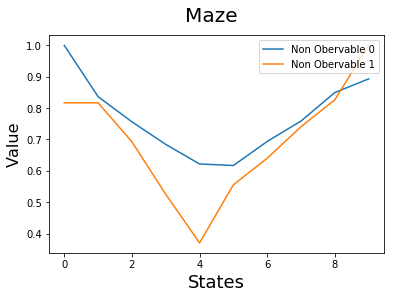

In [9]:
position = np.arange(size_of_maze)
value = np.zeros(size_of_maze)
for z in range (size_of_maze):
    if z == goal_states[0]:
        value[z] = np.dot(weights, convolve(reward_tkn, preconvolved_matrix[0][z])) + bias
    else:
        value[z] = np.dot(weights, preconvolved_matrix[0][z]) + bias
lab = "Non Obervable 0"
plt.plot(position, value, label=lab)
position = np.arange(size_of_maze)
value = np.zeros(size_of_maze)
for z in range (size_of_maze):
    if z == goal_states[1]:
        value[z] = np.dot(weights, convolve(reward_tkn, preconvolved_matrix[0][z])) + bias
    else:
        value[z] = np.dot(weights, preconvolved_matrix[1][z]) + bias
lab = "Non Obervable 1"
plt.plot(position, value, label=lab)
plt.suptitle('Maze', fontsize=20)
plt.xlabel('States', fontsize=18)
plt.ylabel('Value', fontsize=16)
plt.legend(loc='upper right')

In [ ]:
# position = np.arange(size_of_maze)
# value = np.zeros(size_of_maze)
# for z in range (size_of_maze):
#     if z == goal_states[1]:
#         value[z] = np.dot(weights, convolve(reward_tkn, preconvolved_matrix[0][z])) + bias
#     else:
#         value[z] = np.dot(weights, preconvolved_matrix[0][z]) + bias
# plt.plot(position, value)
# print(np.amax(value))
# plt.suptitle('Maze', fontsize=20)
# plt.xlabel('States', fontsize=18)
# plt.ylabel('Value', fontsize=16)